In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway, kruskal, mannwhitneyu
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from scipy import stats

In [2]:
df = pd.read_csv('tyg3.csv')
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,has_ercp,has_vasopressin,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,WHITE,5.166100,0,1,...,0,0,5.166100,14.130556,0,0,0,0,0,0
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,WHITE,0.776481,0,0,...,0,0,0.776481,15.834722,0,0,0,0,0,0
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,WHITE,1.050521,0,1,...,0,0,1.050521,21.834722,0,0,0,0,0,0
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,WHITE,9.019225,1,0,...,0,0,9.019225,17.736806,0,0,0,0,0,0
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,WHITE,0.572477,1,1,...,0,0,0.572477,10.655556,0,0,0,0,0,0


In [3]:
# df['TyG_group'] = pd.qcut(x= df['tyg'], q=4, labels= ['Q1', 'Q2', 'Q3', 'Q4'])
# df.head()

In [4]:
races = {
    'UNKNOWN': 'Others',
    'UNABLE TO OBTAIN': 'Others',
    'ASIAN - CHINESE': 'Others',
    'ASIAN - SOUTH EAST ASIAN': 'Others',
    'ASIAN - ASIAN INDIAN': 'Others',
    'ASIAN - KOREAN': 'Others',
    'ASIAN': 'Others',
    'HISPANIC OR LATINO': 'Others',
    'HISPANIC/LATINO - PUERTO RICAN': 'Others',
    'HISPANIC/LATINO - GUATEMALAN': 'Others',
    'HISPANIC/LATINO - DOMINICAN': 'Others',
    'HISPANIC/LATINO - MEXICAN': 'Others',
    'HISPANIC/LATINO - SALVADORAN': 'Others',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Others',
    'HISPANIC/LATINO - CUBAN': 'Others',
    'HISPANIC/LATINO - COLUMBIAN': 'Others',
    'HISPANIC/LATINO - HONDURAN': 'Others',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Others',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Others',
    'MULTIPLE RACE/ETHNICITY': 'Others',
    'SOUTH AMERICAN': 'Others',
    'OTHER': 'Others',
    'PATIENT DECLINED TO ANSWER': 'Others',
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'PORTUGUESE': 'White',
    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/AFRICAN': 'Black',
}
df['race'] = df['race'].map(races)

In [5]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y'],
      dtype='object')

# Đặc điểm bệnh nhân sepsis và non-sepsis

In [6]:
# Hàm mô tả biến liên tục
def describe_continuous(var, df, results):
    group0 = df[df['sepsis'] == 0][var].dropna()
    group1 = df[df['sepsis'] == 1][var].dropna()
    overall = df[var].dropna()
    
    if len(overall) == 0:
        return results
    
    med_iqr = lambda x: f"{np.median(x):.1f} ({np.percentile(x,25):.2f}–{np.percentile(x,75):.2f})"
    
    n_total = len(df)
    n0, n1 = len(group0), len(group1)
    
    res = {
        'Variable': var,
        f'Overall (N = {n_total})': med_iqr(overall),
        f'Non-sepsis group (N = {n0})': med_iqr(group0),
        f'Sepsis group (N = {n1})': med_iqr(group1),
    }
    
    try:
        stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
        res['P-value'] = '<0.001' if p < 0.001 else f'{p:.3f}'
    except ValueError:
        res['P-value'] = 'NA'
    
    results.append(res)
    return results

In [ ]:
# Hàm mô tả biến phân loại
def chi_square_test(var, df, results):
    obs = pd.crosstab(df[var], df['sepsis'])
    res = chi2_contingency(obs)
    pval = '<0.001' if res.pvalue < 0.001 else f'{res.pvalue:.3f}'
    
    n_total = len(df)
    n_non = (df['sepsis'] == 0).sum()
    n_sep = (df['sepsis'] == 1).sum()
    
    # Hàng tiêu đề
    results.append({
        'Variable': var,
        f'Overall (N = {n_total})': f'N = {n_total}',
        f'Non-sepsis group (N = {n_non})': '',
        f'Sepsis group (N = {n_sep})': '',
        'P-value': pval
    })
    
    # Chi tiết từng giá trị (Female, Male, v.v.)
    overall_counts = df[var].value_counts()
    overall_perc = (overall_counts / n_total * 100).round(1)
    
    for level in obs.index:
        row = {'Variable': f'  {level}'}
        row[f'Overall (N = {n_total})'] = f"{overall_counts[level]} ({overall_perc[level]}%)"
        row[f'Non-sepsis group (N = {n_non})'] = f"{obs.loc[level,0]} ({obs.loc[level,0]/n_non*100:.1f}%)"
        row[f'Sepsis group (N = {n_sep})'] = f"{obs.loc[level,1]} ({obs.loc[level,1]/n_sep*100:.1f}%)"
        row['P-value'] = ''
        results.append(row)
    return results

In [8]:
# Thực hiện thống kê
results = []

continuous_vars = [
    'age', 'wbc','rdw', 'rbc', 'hemoglobin',
    'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
    'potassium', 'creatinine', 'glucose', 'triglycerides',
    'alt', 'alp', 'ast', 'pt', 'ptt', 'inr', 'tyg'
]

categorical_vars = ['gender', 'hypertension', 'diabetes', 'aki', 'mortality_28d', 'mortality_90d']

for var in continuous_vars:
    describe_continuous(var, df, results)

for var in categorical_vars:
    chi_square_test(var, df, results)

baseline_table = pd.DataFrame(results)


n_total = len(df)
n_non = (df['sepsis'] == 0).sum()
n_sep = (df['sepsis'] == 1).sum()

cols_final = [
    'Variable',
    f'Overall (N = {n_total})',
    f'Non-sepsis group (N = {n_non})',
    f'Sepsis group (N = {n_sep})',
    'P-value'
]

baseline_table = baseline_table.reindex(columns=cols_final, fill_value='')

baseline_table

,Variable,Overall (N = 663),Non-sepsis group (N = 429),Sepsis group (N = 234),P-value
0,age,56.0 (44.00–68.00),53.0 (42.00–65.00),60.0 (48.25–71.75),<0.001
1,wbc,20.9 (14.60–30.35),17.9 (13.00–23.70),29.7 (21.85–40.95),<0.001
2,rdw,16.7 (14.90–19.60),15.9 (14.50–18.10),18.6 (16.40–22.00),<0.001
3,rbc,3.2 (2.86–3.69),3.3 (2.91–3.78),3.1 (2.80–3.43),<0.001
4,hemoglobin,12.0 (10.70–13.80),12.2 (10.80–13.90),11.6 (10.50–13.28),0.017
5,platelets,128.0 (72.00–188.00),140.0 (85.00–200.00),107.0 (43.00–171.75),<0.001
6,aniongap,19.0 (17.00–24.00),19.0 (16.00–22.00),22.5 (18.00–27.00),<0.001
7,bicarbonate,23.3 (21.06–25.64),23.8 (21.70–25.82),22.1 (19.77–24.89),<0.001
8,calcium,9.2 (8.80–9.80),9.2 (8.70–9.60),9.4 (8.80–10.50),<0.001
9,chloride,110.0 (106.00–115.00),110.0 (105.00–114.00),112.0 (108.00–116.00),<0.001


# Mối liên hệ gữa TyG và Sepsis

In [9]:

# Chia nhóm TyG theo tứ phân vị
df['TyG_group'] = pd.qcut(df['tyg'], 4, labels=['Q1','Q2','Q3','Q4'])
df['TyG_numeric'] = df['TyG_group'].cat.codes  # cho test p-trend
df.head()

,subject_id,hadm_id,stay_id,intime,age,gender,race,los,diabetes,hypertension,...,los_icu,los_hosp,hosp_mortality,icu_mortality,mortality_7d,mortality_28d,mortality_90d,mortality_1y,TyG_group,TyG_numeric
0,10004606,29242151,30213599,2159-02-20 16:10:03,64,F,White,5.166100,0,1,...,5.166100,14.130556,0,0,0,0,0,0,Q3,2
1,10006441,24120560,37240744,2174-09-12 16:57:04,51,M,White,0.776481,0,0,...,0.776481,15.834722,0,0,0,0,0,0,Q2,1
2,10007795,28477357,31921355,2136-04-22 18:01:13,53,F,White,1.050521,0,1,...,1.050521,21.834722,0,0,0,0,0,0,Q3,2
3,10010888,20162667,33318955,2174-01-09 00:21:00,43,M,White,9.019225,1,0,...,9.019225,17.736806,0,0,0,0,0,0,Q3,2
4,10012206,23961896,37675714,2127-07-04 02:08:00,45,M,White,0.572477,1,1,...,0.572477,10.655556,0,0,0,0,0,0,Q4,3


In [ ]:
# Các biến điều chỉnh
covars = ['age', 'gender', 'wbc','rdw', 'rbc', 'hemoglobin',
    'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
    'potassium', 'creatinine', 'alt', 'alp', 'ast', 'pt', 'ptt', 'inr']

In [ ]:
# Hàm tính OR và CI
def get_or_ci(model, var):
    coef = model.params[var]
    se = model.bse[var]
    OR = np.exp(coef)
    CI_low = np.exp(coef - 1.96 * se)
    CI_high = np.exp(coef + 1.96 * se)
    return f"{OR:.3f}({CI_low:.3f}–{CI_high:.3f})"

In [ ]:
# Các mô hình hồi quy logistic
m1 = smf.logit("sepsis ~ tyg", data=df).fit(disp=False)
m2 = smf.logit("sepsis ~ tyg + age + gender", data=df).fit(disp=False)
m3 = smf.logit("sepsis ~ tyg + " + " + ".join(covars), data=df).fit(disp=False)

# Quartile models (Q1 = ref)
m1_q = smf.logit("sepsis ~ C(TyG_group, Treatment(reference='Q1'))", data=df).fit(disp=False)
m2_q = smf.logit("sepsis ~ C(TyG_group, Treatment(reference='Q1')) + age + gender", data=df).fit(disp=False)
m3_q = smf.logit("sepsis ~ C(TyG_group, Treatment(reference='Q1')) + " + " + ".join(covars), data=df).fit(disp=False)

In [ ]:
# Hàm trích xuất OR theo nhóm TyG
def extract_quartiles(model):
    out = {'Q1': 'Ref'}
    for var in model.params.index:
        if "C(TyG_group" in var:
            # var dạng: C(TyG_group, Treatment(reference='Q1'))[T.Q2]
            grp = var.split('.')[-1].replace(']', '').replace('T.', '')
            out[grp] = get_or_ci(model, var)
    # Đảm bảo đủ thứ tự
    for q in ['Q2', 'Q3', 'Q4']:
        if q not in out:
            out[q] = ''
    return out

q1 = extract_quartiles(m1_q)
q2 = extract_quartiles(m2_q)
q3 = extract_quartiles(m3_q)

In [ ]:
# P for trend
p1 = smf.logit("sepsis ~ TyG_numeric", data=df).fit(disp=False).pvalues['TyG_numeric']
p2 = smf.logit("sepsis ~ TyG_numeric + age + gender", data=df).fit(disp=False).pvalues['TyG_numeric']
p3 = smf.logit("sepsis ~ TyG_numeric + " + " + ".join(covars), data=df).fit(disp=False).pvalues['TyG_numeric']

def format_p(p):
    return "<0.001" if p < 0.001 else f"{p:.3f}"

In [ ]:
# Tạo bảng kết quả
table = pd.DataFrame({
    'Model 1': [
        get_or_ci(m1, 'tyg'),
        q1['Q1'], q1['Q2'], q1['Q3'], q1['Q4'],
        format_p(p1)
    ],
    'Model 2': [
        get_or_ci(m2, 'tyg'),
        q2['Q1'], q2['Q2'], q2['Q3'], q2['Q4'],
        format_p(p2)
    ],
    'Model 3': [
        get_or_ci(m3, 'tyg'),
        q3['Q1'], q3['Q2'], q3['Q3'], q3['Q4'],
        format_p(p3)
    ]
}, index=[
    'TyG index', 'Q1', 'Q2', 'Q3', 'Q4', 'P for trend'
])

# print("\n===== Table 2. Association between TyG index and Sepsis =====\n")
# print(table.to_string())
table

,Model 1,Model 2,Model 3
TyG index,0.608(0.498–0.742),0.654(0.532–0.805),0.800(0.619–1.034)
Q1,Ref,Ref,Ref
Q2,0.539(0.347–0.838),0.536(0.344–0.837),0.538(0.313–0.926)
Q3,0.621(0.401–0.964),0.663(0.425–1.034),0.708(0.414–1.211)
Q4,0.283(0.175–0.457),0.332(0.202–0.546),0.501(0.273–0.918)
P for trend,<0.001,<0.001,0.054


In [16]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y', 'TyG_group', 'TyG_numeric'],
      dtype='object')

C:\Users\nam09\AppData\Local\Temp\ipykernel_19224\4293053738.py:42: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  X1 = dmatrix(m1.model.data.design_info.builder, df_pred1, return_type='dataframe')
C:\Users\nam09\AppData\Local\Temp\ipykernel_19224\4293053738.py:43: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  X2 = dmatrix(m2.model.data.design_info.builder, df_pred2, return_type='dataframe')


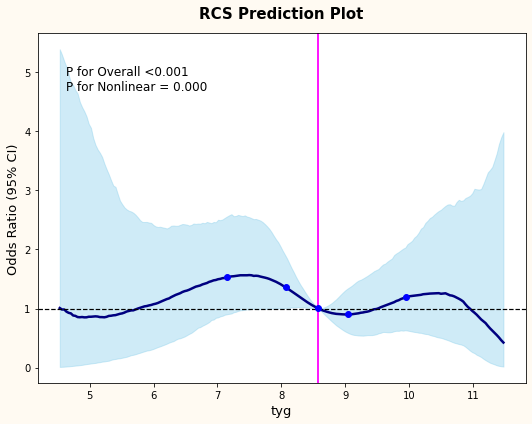

In [17]:


# # ========================================
# # 1️⃣ Chuẩn bị dữ liệu
# # df: phải có các cột 'TyG', 'sepsis', và covariates
# # ========================================
# covars = ['age','gender','wbc', 'rbc', 'rdw', 'hemoglobin', 'platelets',
#            'aniongap', 'bicarbonate', 'calcium', 'chloride', 'potassium', 'creatinine',
#            'alt', 'alp', 'ast', 'ptt', 'pt', 'inr']

# ========================================
# 2️⃣ Xác định spline cho TyG
# ========================================
knots = np.percentile(df['tyg'], [5, 27.5, 50, 72.5, 95])
inner_knots = knots[1:-1]  # 3 knot ở giữa
spline_formula = f"bs(tyg, knots=({inner_knots[0]}, {inner_knots[1]}, {inner_knots[2]}), degree=3, include_intercept=False)"

# ========================================
# 3️⃣ Fit hai mô hình logistic
# ========================================
# Unadjusted
m1 = smf.logit(f"sepsis ~ {spline_formula}", data=df).fit(disp=False)

# Adjusted
formula_adj = f"sepsis ~ {spline_formula} + " + " + ".join(covars)
m2 = smf.logit(formula_adj, data=df).fit(disp=False)

# ========================================
# 4️⃣ Tạo df dự đoán
# ========================================
TyG_seq = np.linspace(df['tyg'].min(), df['tyg'].max(), 200)
df_pred1 = pd.DataFrame({'tyg': TyG_seq})

df_pred2 = df_pred1.copy()
for c in covars:
    if df[c].dtype.kind in 'biufc':
        df_pred2[c] = df[c].median()
    else:
        df_pred2[c] = df[c].mode()[0]

# ========================================
# 5️⃣ Tạo ma trận thiết kế (avoid NameError)
# ========================================
X1 = dmatrix(m1.model.data.design_info.builder, df_pred1, return_type='dataframe')
X2 = dmatrix(m2.model.data.design_info.builder, df_pred2, return_type='dataframe')

# Điểm tham chiếu (median)
ref_idx = np.argmin(abs(TyG_seq - np.median(df['tyg'])))

# ========================================
# 6️⃣ Hàm bootstrap OR ± 95% CI
# ========================================
def bootstrap_or(model, X_pred, ref_idx, n_boot=1000, seed=42):
    np.random.seed(seed)
    params = model.params.values
    cov = model.cov_params().values
    n = X_pred.shape[0]

    boot_odds = np.zeros((n, n_boot))
    for i in range(n_boot):
        sample_params = np.random.multivariate_normal(params, cov)
        lin_pred = np.dot(X_pred.values, sample_params)
        prob = 1 / (1 + np.exp(-lin_pred))
        boot_odds[:, i] = prob / prob[ref_idx]

    odds = np.median(boot_odds, axis=1)
    ci_low = np.percentile(boot_odds, 2.5, axis=1)
    ci_high = np.percentile(boot_odds, 97.5, axis=1)
    return odds, ci_low, ci_high

# Tính OR & CI
odds1, ci1_low, ci1_high = bootstrap_or(m1, X1, ref_idx)
odds2, ci2_low, ci2_high = bootstrap_or(m2, X2, ref_idx)

# ========================================
# 7️⃣ Kiểm định phi tuyến (Adjusted model)
# ========================================
m_lin = smf.logit("sepsis ~ tyg", data=df).fit(disp=False)
LR_nonlin = 2 * (m2.llf - m_lin.llf)
df_diff = m2.df_model - m_lin.df_model
p_nonlin = stats.chi2.sf(LR_nonlin, df_diff)

# ========================================
# 8️⃣ Vẽ biểu đồ OR ± 95% CI (giống hình mẫu)
# ========================================
plt.figure(figsize=(7.5, 6), facecolor="#fffaf2")  # nền sáng dịu

# --- Vẽ đường OR và CI ---
plt.plot(TyG_seq, odds2, color='navy', linewidth=2.5)
plt.fill_between(TyG_seq, ci2_low, ci2_high, color='skyblue', alpha=0.4)

# --- Đường tham chiếu ---
plt.axhline(y=1, color='black', linestyle='--', linewidth=1.2)
plt.axvline(x=TyG_seq[ref_idx], color='magenta', linestyle='-', linewidth=1.8)

# --- Thêm các điểm spline (minh họa) ---
knots_show = np.percentile(df['tyg'], [5, 27.5, 50, 72.5, 95])
plt.scatter(knots_show, np.interp(knots_show, TyG_seq, odds2),
            color='blue', s=35, zorder=5)

# --- Cài đặt trục và nhãn ---
plt.xlabel("tyg", fontsize=13)
plt.ylabel("Odds Ratio (95% CI)", fontsize=13)
plt.title("RCS Prediction Plot", fontsize=15, weight='bold', pad=15)

# --- Thêm text p-value ---
plt.text(df["tyg"].min()+0.1,
         ci2_high.max()*0.95,
         f"P for Overall <0.001\nP for Nonlinear = {p_nonlin:.3f}",
         fontsize=12, ha='left', va='top')

plt.grid(False)
plt.tight_layout()
plt.show()



In [18]:

# # 2. Chia nhóm TyG theo tứ phân vị
# # -------------------------------
# df['TyG_group'] = pd.qcut(df['tyg'], 4, labels=['Q1','Q2','Q3','Q4'])
# df['TyG_numeric'] = df['TyG_group'].cat.codes + 1  # cho test p-trend

# # -------------------------------
# # 3. Các biến điều chỉnh
# # -------------------------------
# covars = ["age","gender","wbc","rbc","rdw","hemoglobin","platelets",
#           "aniongap","bicarbonate","calcium","chloride","potassium",
#           "creatinine","alt","alp","ast","pt","ptt","inr"]



# # -------------------------------
# # 4. Hàm tính OR và CI
# # -------------------------------
# def get_or_ci(model, var):
#     coef = model.params[var]
#     se = model.bse[var]
#     OR = np.exp(coef)
#     CI_low = np.exp(coef - 1.96 * se)
#     CI_high = np.exp(coef + 1.96 * se)
#     return f"{OR:.3f}({CI_low:.3f}–{CI_high:.3f})"

# # -------------------------------
# # 5. Các mô hình hồi quy logistic
# # -------------------------------
# m1 = smf.logit("sepsis ~ tyg", data=df).fit(disp=False)
# m2 = smf.logit("sepsis ~ tyg + age + gender", data=df).fit(disp=False)
# m3 = smf.logit("sepsis ~ tyg + " + " + ".join(covars), data=df).fit(disp=False)

# # Quartile models (Q1 = ref)
# m1_q = smf.logit("sepsis ~ C(TyG_group, Treatment(reference='Q1'))", data=df).fit(disp=False)
# m2_q = smf.logit("sepsis ~ C(TyG_group, Treatment(reference='Q1')) + age + gender", data=df).fit(disp=False)
# m3_q = smf.logit("sepsis ~ C(TyG_group, Treatment(reference='Q1')) + " + " + ".join(covars), data=df).fit(disp=False)

# # -------------------------------
# # 6. Hàm trích xuất OR theo nhóm TyG
# # -------------------------------
# def extract_quartiles(model):
#     out = {'Q1': 'Ref'}
#     for var in model.params.index:
#         if "C(TyG_group" in var:
#             # var dạng: C(TyG_group, Treatment(reference='Q1'))[T.Q2]
#             grp = var.split('.')[-1].replace(']', '').replace('T.', '')
#             out[grp] = get_or_ci(model, var)
#     # Đảm bảo đủ thứ tự
#     for q in ['Q2', 'Q3', 'Q4']:
#         if q not in out:
#             out[q] = ''
#     return out

# q1 = extract_quartiles(m1_q)
# q2 = extract_quartiles(m2_q)
# q3 = extract_quartiles(m3_q)

# # -------------------------------
# # 7. P for trend
# # -------------------------------
# p1 = smf.logit("sepsis ~ TyG_numeric", data=df).fit(disp=False).pvalues['TyG_numeric']
# p2 = smf.logit("sepsis ~ TyG_numeric + age + gender", data=df).fit(disp=False).pvalues['TyG_numeric']
# p3 = smf.logit("sepsis ~ TyG_numeric + " + " + ".join(covars), data=df).fit(disp=False).pvalues['TyG_numeric']

# def format_p(p):
#     return "<0.001" if p < 0.001 else f"{p:.3f}"

# # -------------------------------
# # 8. Tạo bảng kết quả như Table 2
# # -------------------------------
# table = pd.DataFrame({
#     'Model 1': [
#         get_or_ci(m1, 'tyg'),
#         q1['Q1'], q1['Q2'], q1['Q3'], q1['Q4'],
#         format_p(p1)
#     ],
#     'Model 2': [
#         get_or_ci(m2, 'tyg'),
#         q2['Q1'], q2['Q2'], q2['Q3'], q2['Q4'],
#         format_p(p2)
#     ],
#     'Model 3': [
#         get_or_ci(m3, 'tyg'),
#         q3['Q1'], q3['Q2'], q3['Q3'], q3['Q4'],
#         format_p(p3)
#     ]
# }, index=[
#     'TyG index', 'Q1 (Ref)', 'Q2', 'Q3', 'Q4', 'P for trend'
# ])

# # print("\n===== Table 2. Association between TyG index and Sepsis =====\n")
# # print(table.to_string())
# table


# Phân tích nhóm con 

In [19]:


# Biến số thứ tự để test p-trend
df['TyG_numeric'] = df['TyG_group'].cat.codes + 1


In [20]:
def get_or_ci(model, var):
    coef = model.params[var]
    se   = model.bse[var]
    OR = np.exp(coef)
    CI_low = np.exp(coef - 1.96*se)
    CI_high = np.exp(coef + 1.96*se)
    return f"{OR:.3f}({CI_low:.3f}–{CI_high:.3f})"


In [21]:
df['age_group'] = np.where(df['age'] >= 65, '>=65', '<65')
df['gender_group'] = df['gender']
df['htn_group'] = np.where(df['hypertension'] == 1, 'Yes', 'No')
df['dm_group'] = np.where(df['diabetes'] == 1, 'Yes', 'No')


In [22]:
subgroups = {
    'Age': ('age_group', ['>=65', '<65']),
    'Gender': ('gender_group', ['M', 'F']),
    'Hypertension': ('htn_group', ['Yes', 'No']),
    'Diabetes': ('dm_group', ['Yes', 'No'])
}

def count_case_total(df, var, lvl):
    sub = df[df[var] == lvl]
    case = sub['sepsis'].sum()
    total = sub.shape[0]
    return case, total




In [23]:
def run_subgroup(df, var, lvl, covars):

    sub = df[df[var] == lvl].copy()

    # --- Nếu số ca < 20 thì bỏ qua để tránh lỗi ---
    if sub.shape[0] < 20 or sub['sepsis'].nunique() < 2:
        return {"Q2":"", "Q3":"", "Q4":""}, np.nan
    
    try:
        # Q1 = Ref
        formula = "sepsis ~ C(TyG_group, Treatment(reference='Q1')) + " + " + ".join(covars)
        model = smf.logit(formula, data=sub).fit(disp=False)

        ORs = {}
        for param in model.params.index:
            if "C(TyG_group" in param:
                q = param.split('T.')[1].replace(']','')
                coef = model.params[param]
                se = model.bse[param]
                OR = np.exp(coef)
                L = np.exp(coef - 1.96*se)
                U = np.exp(coef + 1.96*se)
                ORs[q] = f"{OR:.3f}({L:.3f}–{U:.3f})"

        # P-trend
        model_trend = smf.logit("sepsis ~ TyG_numeric + " + " + ".join(covars), data=sub).fit(disp=False)
        p_trend = model_trend.pvalues['TyG_numeric']

        return ORs, p_trend

    except Exception as e:
        # Nếu subgroup lỗi, trả về rỗng
        return {"Q2":"", "Q3":"", "Q4":""}, np.nan


In [24]:
def p_interaction(df, subgroup_var, covars):
    # dùng numeric TyG để kiểm định interaction
    if "TyG_numeric" not in df.columns:
        df["TyG_numeric"] = df["TyG_group"].cat.codes

    formula = "sepsis ~ TyG_numeric * C(" + subgroup_var + ") + " + " + ".join(covars)

    try:
        model = smf.logit(formula, data=df).fit(disp=False)
        return model.pvalues.filter(like="TyG_numeric:C").min()
    except:
        return np.nan


In [25]:
covars_full = ['age','gender','wbc', 'rbc', 'rdw', 'hemoglobin', 'platelets',
           'aniongap', 'bicarbonate', 'calcium', 'chloride', 'potassium', 'creatinine',
           'alt', 'alp', 'ast', 'ptt', 'pt', 'inr']

rows = []

for subgroup_name, (var, levels) in subgroups.items():

    p_int = p_interaction(df, var, covars_full)

    for lvl in levels:

        # CASE & TOTAL
        case, total = count_case_total(df, var, lvl)

        # OR Q2-Q4 + P-trend
        ORs, p_trend = run_subgroup(df, var, lvl, covars_full)

        rows.append({
            "Subgroup": subgroup_name,
            "Level": lvl,
            "CASE": case,
            "TOTAL": total,
            "Q1": "Ref",
            "Q2": ORs.get("Q2",""),
            "Q3": ORs.get("Q3",""),
            "Q4": ORs.get("Q4",""),
            "P for trend": "" if pd.isna(p_trend) else ("<0.001" if p_trend < 0.001 else f"{p_trend:.3f}"),
            "P for interaction": "" if pd.isna(p_int) else ("<0.001" if p_int < 0.001 else f"{p_int:.3f}")
        })

table3 = pd.DataFrame(rows)
table3


,Subgroup,Level,CASE,TOTAL,Q1,Q2,Q3,Q4,P for trend,P for interaction
0,Age,>=65,94,214,Ref,0.515(0.229–1.156),0.673(0.281–1.610),0.279(0.082–0.946),0.060,0.366
1,Age,<65,140,449,Ref,0.650(0.299–1.414),0.846(0.407–1.757),0.682(0.319–1.459),0.471,0.366
2,Gender,M,140,389,Ref,0.613(0.301–1.250),0.574(0.276–1.196),0.433(0.199–0.945),0.039,0.586
3,Gender,F,94,274,Ref,0.493(0.198–1.228),0.924(0.383–2.224),0.751(0.265–2.129),0.811,0.586
4,Hypertension,Yes,78,265,Ref,0.277(0.110–0.699),0.383(0.149–0.986),0.311(0.104–0.931),0.035,0.093
5,Hypertension,No,156,398,Ref,0.651(0.316–1.337),0.816(0.407–1.636),0.591(0.273–1.280),0.264,0.093
6,Diabetes,Yes,76,201,Ref,0.263(0.083–0.832),0.651(0.206–2.059),0.161(0.045–0.578),0.022,0.029
7,Diabetes,No,158,462,Ref,0.706(0.370–1.347),0.779(0.408–1.488),0.882(0.423–1.837),0.713,0.029


## rời rạc -> Chi-square
## liên tục -> nomal = F-test, ko nomal = Kruskal

## Chi-square test
Chọn mức ý nghĩa alpha = 0.05

Giả thuyết

H_0: kiểm tra ảnh hưởng của Male và Female có giống nhau không

H_1: Male và Female khác nhau => (bác bỏ H0 -> pvalue < alpha)


In [26]:
# var = 'gender'
# obs = pd.crosstab(df[var], df['npar_group'])
# res = chi2_contingency(obs)
# res.pvalue


def chi_square_test(var, results):
    obs = pd.crosstab(df[var], df['TyG_group'])
    res = chi2_contingency(obs)
    results.append({
        'Variable': var,
        'Q1': '',
        'Q2': '',
        'Q3': '',
        'Q4': '',
        'pvalue': '<0.001' if res.pvalue < 0.001 else f'{res.pvalue:.3f}'
    })
    percents = obs.div(obs.sum(axis=1), axis=0) * 100
    tabs = obs.astype(str) + '(' + percents.round(1).astype(str) + '%)'
    for name in obs.index:
        dic = {}
        dic['Variable'] = name
        for col in obs.columns:
            dic[col] = tabs.loc[name, col]
        dic['pvalue'] = ''
        results.append(dic)
    return results
results = []
vars = ['gender', 'race','aki', 'diabetes', 'hypertension', 'mortality_28d', 'mortality_90d', 'sepsis']
for var in vars:
    chi_square_test(var, results)
pd.DataFrame(results)



,Variable,Q1,Q2,Q3,Q4,pvalue
0,gender,,,,,0.656
1,F,73(26.6%),72(26.3%),67(24.5%),62(22.6%),
2,M,93(23.9%),96(24.7%),97(24.9%),103(26.5%),
3,race,,,,,0.161
4,Black,25(37.3%),14(20.9%),13(19.4%),15(22.4%),
5,Others,36(19.5%),47(25.4%),52(28.1%),50(27.0%),
6,White,105(25.5%),107(26.0%),99(24.1%),100(24.3%),
7,aki,,,,,0.083
8,0,83(22.7%),86(23.5%),94(25.7%),103(28.1%),
9,1,83(27.9%),82(27.6%),70(23.6%),62(20.9%),


In [27]:
# import pandas as pd
# from scipy.stats import chi2_contingency, mannwhitneyu
# import numpy as np

# # ⚙️ Hàm mô tả biến liên tục
# def describe_continuous(var, df, results):
#     group0 = df[df['sepsis'] == 0][var].dropna()
#     group1 = df[df['sepsis'] == 1][var].dropna()
#     overall = df[var].dropna()
    
#     if len(overall) == 0:
#         return results
    
#     med_iqr = lambda x: f"{np.median(x):.1f} ({np.percentile(x,25):.2f}–{np.percentile(x,75):.2f})"
    
#     n_total = len(df)
#     n0, n1 = len(group0), len(group1)
    
#     res = {
#         'Variable': var,
#         f'Overall (N = {n_total})': med_iqr(overall),
#         f'Non-sepsis group (N = {n0})': med_iqr(group0),
#         f'Sepsis group (N = {n1})': med_iqr(group1),
#     }
    
#     try:
#         stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
#         res['P-value'] = '<0.001' if p < 0.001 else f'{p:.3f}'
#     except ValueError:
#         res['P-value'] = 'NA'
    
#     results.append(res)
#     return results


# # ⚙️ Hàm mô tả biến phân loại
# def chi_square_test(var, df, results):
#     obs = pd.crosstab(df[var], df['sepsis'])
#     res = chi2_contingency(obs)
#     pval = '<0.001' if res.pvalue < 0.001 else f'{res.pvalue:.3f}'
    
#     n_total = len(df)
#     n_non = (df['sepsis'] == 0).sum()
#     n_sep = (df['sepsis'] == 1).sum()
    
#     # Hàng tiêu đề
#     results.append({
#         'Variable': var,
#         f'Overall (N = {n_total})': f'N = {n_total}',
#         f'Non-sepsis group (N = {n_non})': '',
#         f'Sepsis group (N = {n_sep})': '',
#         'P-value': pval
#     })
    
#     # Chi tiết từng giá trị (Female, Male, v.v.)
#     overall_counts = df[var].value_counts()
#     overall_perc = (overall_counts / n_total * 100).round(1)
    
#     for level in obs.index:
#         row = {'Variable': f'  {level}'}
#         row[f'Overall (N = {n_total})'] = f"{overall_counts[level]} ({overall_perc[level]}%)"
#         row[f'Non-sepsis group (N = {n_non})'] = f"{obs.loc[level,0]} ({obs.loc[level,0]/n_non*100:.1f}%)"
#         row[f'Sepsis group (N = {n_sep})'] = f"{obs.loc[level,1]} ({obs.loc[level,1]/n_sep*100:.1f}%)"
#         row['P-value'] = ''
#         results.append(row)
#     return results


# # 📊 Thực hiện thống kê
# results = []

# continuous_vars = [
#     'age', 'wbc','rdw', 'rbc', 'hemoglobin', 'aki',
#     'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
#     'potassium', 'creatinine', 'glucose', 'triglycerides',
#     'alt', 'alp', 'ast', 'pt', 'ptt', 'inr', 'tyg', 'mortality_28d', 'mortality_90d'
# ]

# categorical_vars = ['gender', 'hypertension', 'diabetes']

# for var in continuous_vars:
#     describe_continuous(var, df, results)

# for var in categorical_vars:
#     chi_square_test(var, df, results)

# baseline_table = pd.DataFrame(results)


# n_total = len(df)
# n_non = (df['sepsis'] == 0).sum()
# n_sep = (df['sepsis'] == 1).sum()

# cols_final = [
#     'Variable',
#     f'Overall (N = {n_total})',
#     f'Non-sepsis group (N = {n_non})',
#     f'Sepsis group (N = {n_sep})',
#     'P-value'
# ]

# baseline_table = baseline_table.reindex(columns=cols_final, fill_value='')

# baseline_table


# F-Test

$$H0: \mu Q1 = \mu Q2 = \mu Q3 = \mu Q4 
% $$H0: \mu_{Q_1} = \mu_{Q_2} = \mu_{Q_3} = \mu_{Q_4}$$ 

In [28]:
# def f_test(var, results):
#     #names = sorted(df['NPAR_group'].unique().tolist())
#     names = ['Q1', 'Q2', 'Q3', 'Q4']
#     groups = [df[df['TyG_group'] == name][var].dropna() for name in names]
#     res = f_oneway(*groups)
#     dic = {}
#     dic['Variable'] = var
#     dic['Total'] = f'{df[var].mean():.1f} ± {df[var].std():.1f}'
#     for name, group in zip(names, groups):
#         dic[name] = f'{group.mean():.1f} ± {group.std():.1f}'
#     dic['pvalue'] = '<0.001' if res.pvalue < 0.001 else f'{res.pvalue:.3f}'
#     results.append(dic)
#     return results

# results = []
# vars = ['age',
#        'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
#        'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
#        'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
#        'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
#        'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
#        'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
#        'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
#        'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
#        'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d'
# ]
# for var in vars:
#     f_test(var, results)
# pd.DataFrame(results)


In [29]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y', 'TyG_group', 'TyG_numeric', 'age_group', 'gender_group',
       'htn_group', 'dm_group'],
      dtype='object')

In [30]:
def f_test(var, df, results):
    names = ['Q1', 'Q2', 'Q3', 'Q4']
    groups = [df[df['TyG_group'] == name][var].dropna() for name in names]
    res = f_oneway(*groups)
    dic = {}
    dic['Variable'] = var
    dic['Total'] = f"{df[var].mean():.1f} ± {df[var].std():.1f}"
    for name, group in zip(names, groups):
        dic[name] = f"{group.mean():.1f} ± {group.std():.1f}"
    dic['P-value'] = "<0.001" if res.pvalue < 0.001 else f"{res.pvalue:.3f}"
    results.append(dic)
    return results
results = []
vars = [
    'age','platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
    'potassium', 'creatinine', 'glucose', 'triglycerides', 
    'alt', 'alp', 'ast', 'pt', 'ptt', 'inr'
]
for var in vars:
    f_test(var, df, results)
table = pd.DataFrame(results, columns=['Variable', 'Total', 'Q1', 'Q2', 'Q3', 'Q4', 'P-value'])
table


,Variable,Total,Q1,Q2,Q3,Q4,P-value
0,age,56.2 ± 16.5,60.5 ± 17.1,60.0 ± 16.1,55.7 ± 15.4,48.6 ± 14.6,<0.001
1,platelets,143.1 ± 100.7,121.9 ± 82.0,153.2 ± 104.1,143.4 ± 115.3,153.7 ± 96.0,0.012
2,aniongap,21.2 ± 6.5,21.8 ± 6.6,19.8 ± 5.5,21.8 ± 7.0,21.5 ± 6.5,0.009
3,bicarbonate,23.2 ± 3.6,22.9 ± 3.6,23.8 ± 3.6,23.3 ± 3.4,22.9 ± 3.7,0.072
4,calcium,9.4 ± 1.1,9.6 ± 1.3,9.4 ± 1.0,9.4 ± 1.1,9.3 ± 0.8,0.157
5,chloride,110.7 ± 6.8,111.5 ± 6.4,111.7 ± 6.6,110.9 ± 6.5,108.7 ± 7.1,<0.001
6,potassium,5.4 ± 1.1,5.6 ± 1.2,5.3 ± 1.2,5.4 ± 1.1,5.2 ± 0.9,0.026
7,creatinine,2.8 ± 2.7,2.9 ± 2.5,2.5 ± 2.2,3.0 ± 3.0,2.7 ± 2.8,0.299
8,glucose,81.6 ± 24.7,65.1 ± 20.6,77.7 ± 16.2,84.2 ± 18.7,99.7 ± 28.2,<0.001
9,triglycerides,177.2 ± 174.5,68.0 ± 32.4,111.9 ± 31.2,175.3 ± 43.8,355.4 ± 265.7,<0.001


# Kruskal-test


In [31]:
def kruskal_test(var, results):
    #names = sorted(df['NPAR_group'].unique().tolist())
    names = ['Q1', 'Q2', 'Q3', 'Q4']
    groups = [df[df['TyG_group'] == name][var].dropna() for name in names]
    res = kruskal(*groups)
    dic = {}
    dic['Variable'] = var
    dic['Total'] = f'{df[var].median():.1f} {df[var].quantile(0.25):.1f} - {df[var].quantile(0.75):.1f}'
    for name, group in zip(names, groups):
        dic[name] = f'{group.median():.1f} ± {group.quantile(0.25):.1f} - {group.quantile(0.75):.1f}'
    dic['pvalue'] = '<0.001' if res.pvalue < 0.001 else f'{res.pvalue:.3f}'
    results.append(dic)
    return results

results = []
vars = ['age','platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
    'potassium', 'creatinine', 'glucose', 'triglycerides', 
    'alt', 'alp', 'ast', 'pt', 'ptt', 'inr', 'tyg']
for var in vars:
    kruskal_test(var, results)
pd.DataFrame(results)

,Variable,Total,Q1,Q2,Q3,Q4,pvalue
0,age,56.0 44.0 - 68.0,60.0 ± 48.0 - 74.5,61.0 ± 49.8 - 74.2,56.0 ± 44.8 - 66.0,47.0 ± 37.0 - 58.0,<0.001
1,platelets,128.0 72.0 - 188.0,115.0 ± 52.5 - 164.0,136.0 ± 91.8 - 201.2,121.5 ± 57.5 - 188.0,140.0 ± 88.0 - 202.0,0.005
2,aniongap,19.0 17.0 - 24.0,20.0 ± 17.0 - 25.8,18.5 ± 16.0 - 22.0,20.0 ± 17.0 - 26.0,20.0 ± 17.0 - 24.0,0.006
3,bicarbonate,23.3 21.1 - 25.6,22.9 ± 20.7 - 25.3,24.3 ± 21.5 - 25.9,23.1 ± 21.1 - 25.9,22.9 ± 21.1 - 25.0,0.045
4,calcium,9.2 8.8 - 9.8,9.3 ± 8.7 - 10.2,9.2 ± 8.8 - 9.8,9.2 ± 8.8 - 9.8,9.2 ± 8.8 - 9.7,0.693
5,chloride,110.0 106.0 - 115.0,111.0 ± 107.0 - 115.0,111.0 ± 107.0 - 116.0,110.0 ± 106.0 - 115.0,109.0 ± 104.0 - 112.0,<0.001
6,potassium,5.1 4.6 - 5.8,5.3 ± 4.7 - 6.2,5.0 ± 4.6 - 5.7,5.0 ± 4.6 - 5.9,5.0 ± 4.6 - 5.6,0.015
7,creatinine,1.6 0.9 - 3.8,2.0 ± 1.0 - 4.1,1.5 ± 1.0 - 3.3,1.6 ± 0.9 - 4.1,1.4 ± 0.8 - 3.6,0.154
8,glucose,79.0 68.0 - 94.0,67.0 ± 53.0 - 77.8,78.0 ± 67.0 - 89.0,83.0 ± 73.0 - 91.0,95.0 ± 81.0 - 111.0,<0.001
9,triglycerides,138.0 85.5 - 212.5,68.0 ± 47.2 - 80.0,106.0 ± 88.8 - 129.5,169.0 ± 145.0 - 198.0,296.0 ± 223.0 - 415.0,<0.001


In [32]:
df.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'intime', 'age', 'gender', 'race',
       'los', 'diabetes', 'hypertension', 'wbc', 'rbc', 'rdw', 'hemoglobin',
       'platelets', 'aniongap', 'bicarbonate', 'calcium', 'chloride',
       'potassium', 'creatinine', 'glucose', 'triglycerides', 'alt', 'alp',
       'ast', 'pt', 'ptt', 'inr', 'neutrophils_max', 'neutrophils_min',
       'albumin_max', 'albumin_min', 'bun_max', 'bun_min', 'sepsis',
       'sepsis_3', 'npar', 'tyg', 'sofa', 'has_sepsis', 'aki',
       'has_chronic_kidney_disease', 'has_crrt', 'has_mv', 'has_ercp',
       'has_vasopressin', 'los_icu', 'los_hosp', 'hosp_mortality',
       'icu_mortality', 'mortality_7d', 'mortality_28d', 'mortality_90d',
       'mortality_1y', 'TyG_group', 'TyG_numeric', 'age_group', 'gender_group',
       'htn_group', 'dm_group'],
      dtype='object')